# 🚀 NASA CMAPSS — Sensor Validation & Fault Identification
### DRDO / GTRE | Turbofan Engine Health Monitoring

---

| Milestone | Task | Delivery |
|-----------|------|----------|
| **M1** | Data Analysis, Pre-processing | TO+1 month |
| **M2** | Independent Analysis, Sensor Characterisation | TO+3 months |
| **M3** | Clustering & Data Fusion | TO+4 months |
| **M4** | Faulty Sensor Identification | TO+6 months |

**Dataset**: NASA CMAPSS FD001 — 21 sensors, 100 engines, run-to-failure

## 0 · Setup & Imports

In [2]:
import sys, warnings
from pathlib import Path
warnings.filterwarnings('ignore')

# Add project root to path so we can import src/
ROOT = Path(r'C:\Users\Admin\Desktop\sensor-ml-project-v2').resolve()   # notebook is inside notebooks/
sys.path.insert(0, str(ROOT))

import numpy  as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import zscore, ttest_ind, wasserstein_distance

from sklearn.preprocessing   import MinMaxScaler, StandardScaler
from sklearn.decomposition   import PCA
from sklearn.cluster         import KMeans
from sklearn.metrics         import silhouette_score
from sklearn.ensemble        import IsolationForest
from sklearn.neighbors       import LocalOutlierFactor
from sklearn.model_selection import train_test_split
from sklearn.metrics         import (mean_squared_error, mean_absolute_error,
                                      r2_score, roc_auc_score, roc_curve,
                                      confusion_matrix, classification_report,
                                      f1_score, accuracy_score)
import xgboost as xgb

# Project modules
from src.utils.helpers           import load_config, get_logger, save_artifact
from src.data.make_dataset       import load_cmapss, load_rul, compute_train_rul, attach_test_rul
from src.data.preprocess         import (identify_sensors, drop_useless_cols,
                                          impute_missing, clip_outliers, rolling_smooth)
from src.features.build_features import (add_rolling_features, find_significant_sensors,
                                          compute_health_index, find_best_k)
from src.models.predict          import SensorValidator, sensor_fault_scores

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
pd.set_option('display.max_columns', 30)

CFG = load_config('../config/config.yaml')
print('✅ All imports successful')
print(f'Dataset: {CFG["data"]["dataset_id"]}')

✅ All imports successful
Dataset: FD001


---
## ✅ M1 · Data Analysis Stage

### 1.1 Load Raw Data

In [3]:
DATA = Path('../data/raw')
DID  = CFG['data']['dataset_id']
CLIP = CFG['preprocessing']['rul_clip']

df_train = load_cmapss(DATA / CFG['data']['train_file'])
df_test  = load_cmapss(DATA / CFG['data']['test_file'])
df_rul   = load_rul   (DATA / CFG['data']['rul_file'])

# Compute RUL labels
df_train = compute_train_rul(df_train, clip=CLIP)
df_test  = attach_test_rul(df_test, df_rul, clip=CLIP)

print(f'Train  : {df_train.shape}   engines: {df_train.unit_id.nunique()}')
print(f'Test   : {df_test.shape}    engines: {df_test.unit_id.nunique()}')
print(f'RUL min/max: {df_train.RUL.min()} / {df_train.RUL.max()}')
df_train.head()

Train  : (20631, 27)   engines: 100
Test   : (13096, 27)    engines: 100
RUL min/max: 0 / 125


,unit_id,cycle,op_setting_1,op_setting_2,op_setting_3,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21,RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,125
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,125
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,125
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,1.3,47.13,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,125
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,1.3,47.28,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,125


### 1.2 Identify Active Sensors

In [4]:
ACTIVE, CONST = identify_sensors(df_train,
                                  CFG['preprocessing']['std_threshold'])
print(f'Constant sensors (dropped) : {CONST}')
print(f'Active sensors  ({len(ACTIVE)})  : {ACTIVE}')

Constant sensors (dropped) : ['s1', 's5', 's6', 's10', 's16', 's18', 's19']
Active sensors  (14)  : ['s2', 's3', 's4', 's7', 's8', 's9', 's11', 's12', 's13', 's14', 's15', 's17', 's20', 's21']


### 1.3 Sensor Value Distributions

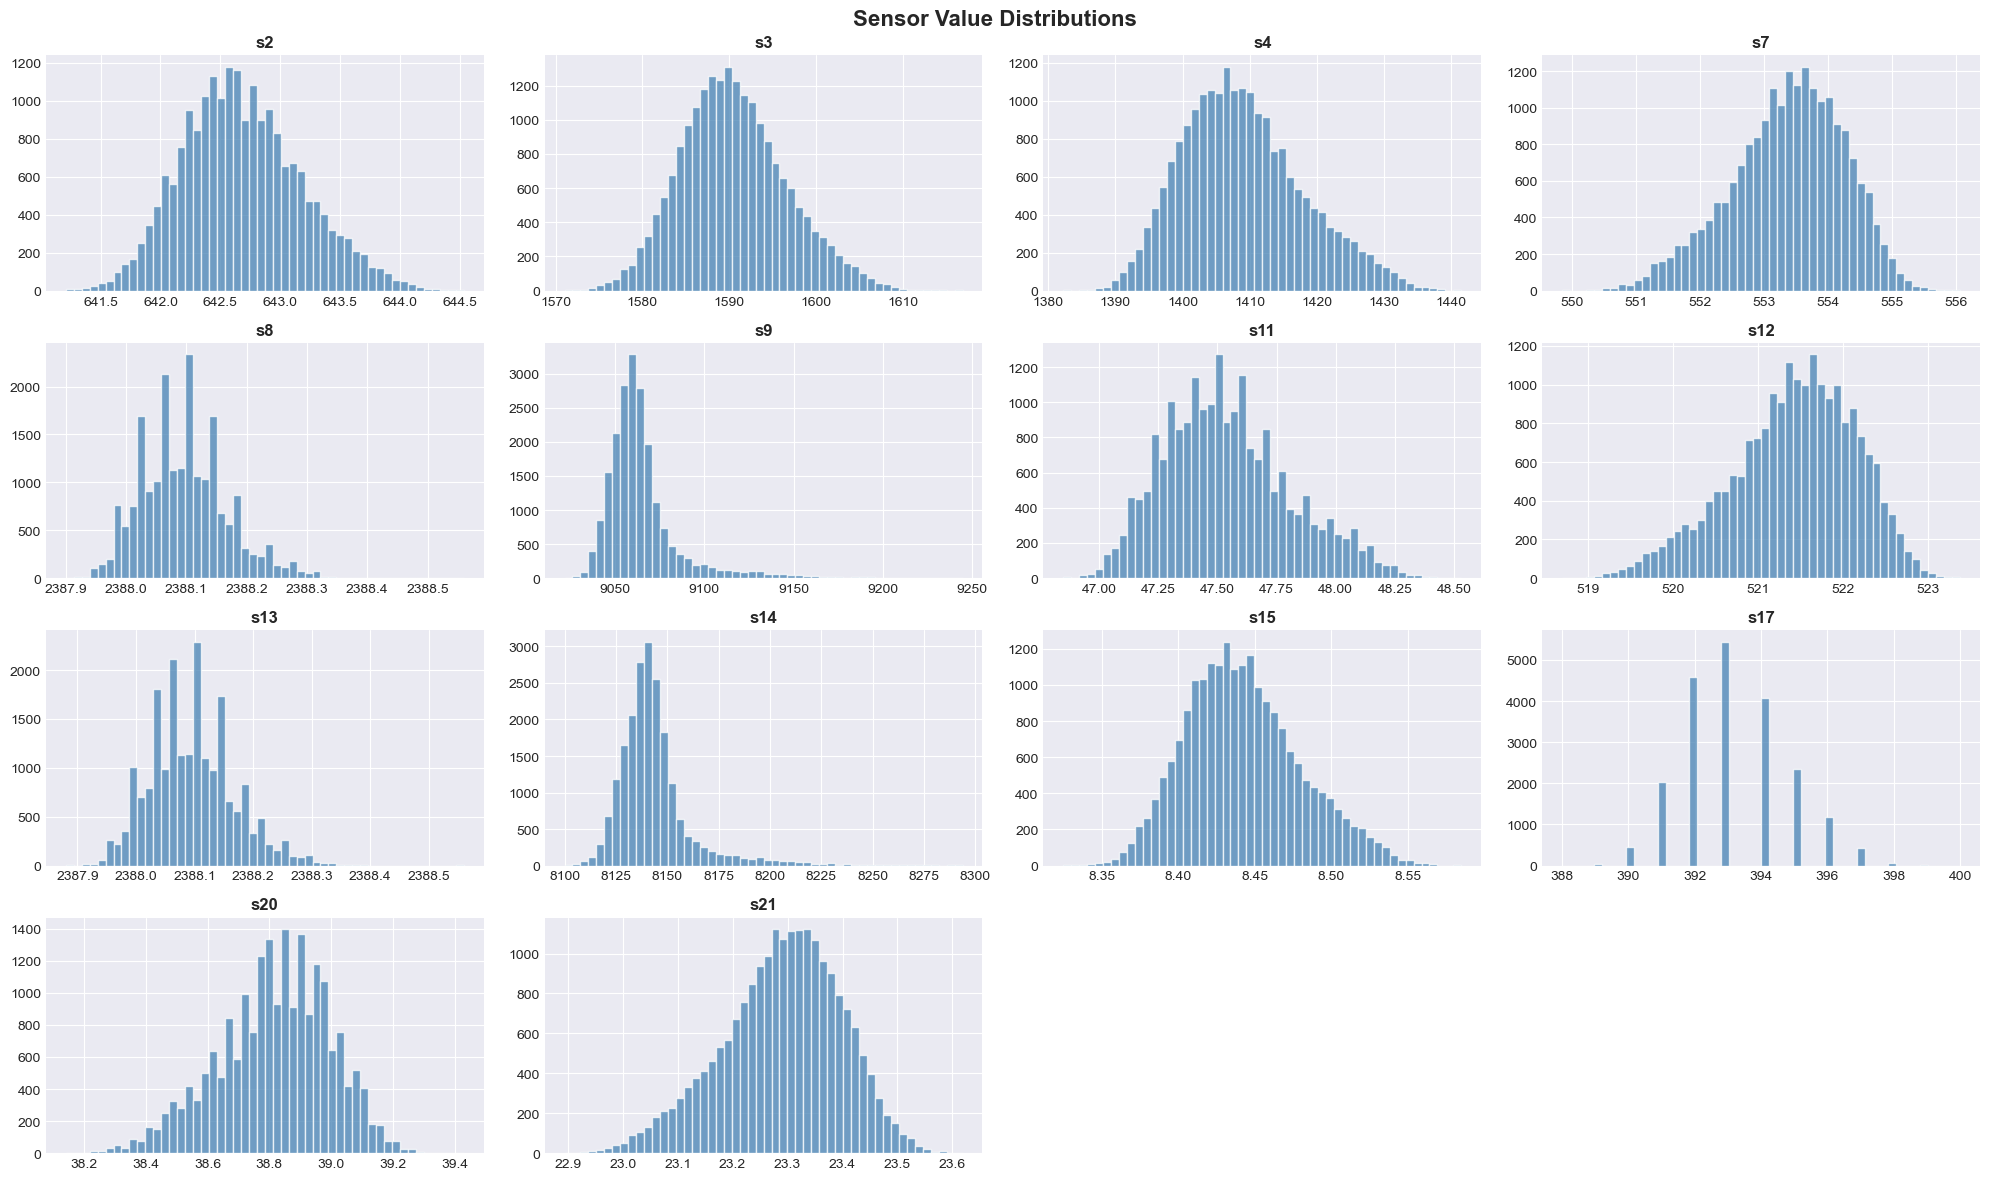

In [5]:
n, cols = len(ACTIVE), 4
rows    = (n + cols - 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(20, rows*3))
axes = axes.flatten()
for i, s in enumerate(ACTIVE):
    axes[i].hist(df_train[s], bins=50, color='steelblue',
                 alpha=0.75, edgecolor='white')
    axes[i].set_title(s, fontweight='bold')
for j in range(i+1, len(axes)):
    axes[j].set_visible(False)
fig.suptitle('Sensor Value Distributions', fontsize=16, fontweight='bold')
fig.tight_layout()
fig.savefig('../reports/figures/01_sensor_distributions.png', dpi=150)
plt.show()

### 1.4 Sensor Trends Over Engine Life

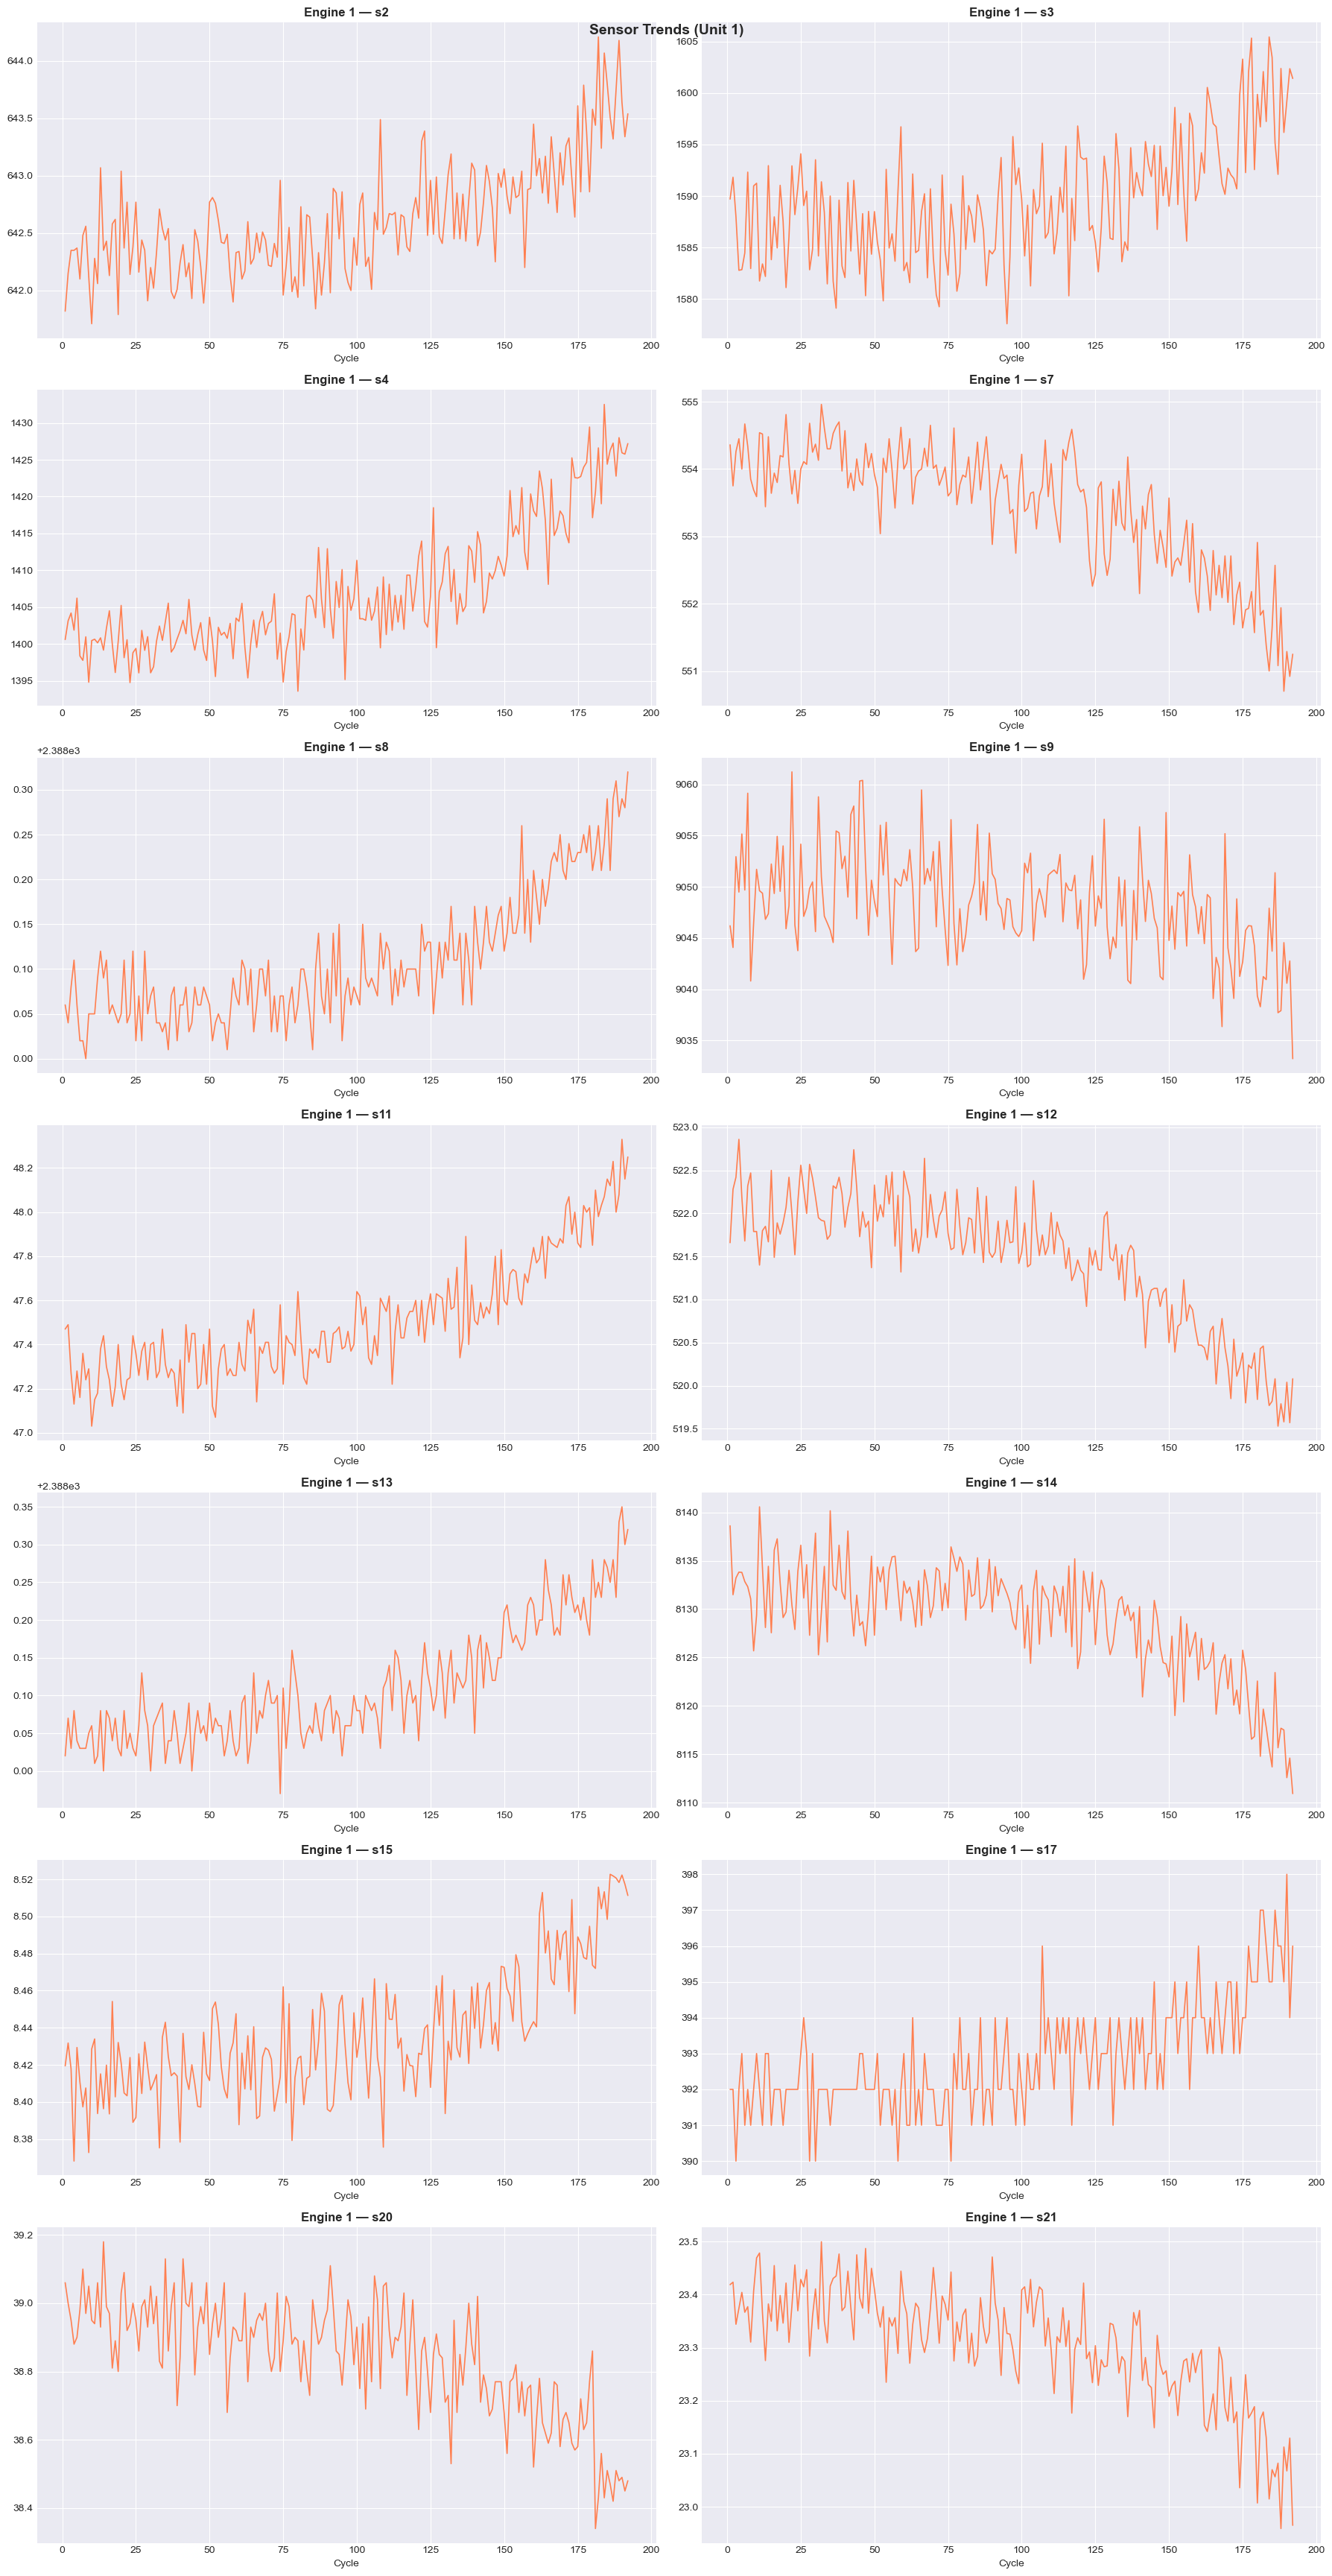

In [6]:
uid  = 1
eng  = df_train[df_train.unit_id == uid]
n    = len(ACTIVE)
fig, axes = plt.subplots((n+1)//2, 2, figsize=(18, n*2.5))
axes = axes.flatten()
for i, s in enumerate(ACTIVE):
    axes[i].plot(eng.cycle, eng[s], color='coral', linewidth=1.2)
    axes[i].set_title(f'Engine {uid} — {s}', fontweight='bold')
    axes[i].set_xlabel('Cycle')
for j in range(i+1, len(axes)):
    axes[j].set_visible(False)
fig.suptitle(f'Sensor Trends (Unit {uid})', fontsize=14, fontweight='bold')
fig.tight_layout()
fig.savefig('../reports/figures/02_sensor_trends_engine1.png', dpi=150)
plt.show()

### 1.5 Data Pre-Processing & Cleaning

In [7]:
import logging
_log = logging.getLogger('notebook')
logging.basicConfig(level=logging.INFO)

# Drop constant sensors + operating settings
tr = drop_useless_cols(df_train, CONST)
te = drop_useless_cols(df_test,  CONST)

# Impute missing (none expected in CMAPSS)
tr = impute_missing(tr, ACTIVE, _log)
te = impute_missing(te, ACTIVE, _log)

# Clip outliers
tr = clip_outliers(tr, ACTIVE, CFG['preprocessing']['outlier_iqr_factor'])
te = clip_outliers(te, ACTIVE, CFG['preprocessing']['outlier_iqr_factor'])

# Rolling smooth
W  = CFG['preprocessing']['rolling_window']
tr = rolling_smooth(tr, ACTIVE, W)
te = rolling_smooth(te, ACTIVE, W)

# Life fraction
for df in [tr, te]:
    mx = df.groupby('unit_id')['cycle'].transform('max')
    df['life_pct'] = df['cycle'] / mx

# MinMax scale
scaler = MinMaxScaler()
tr[ACTIVE] = scaler.fit_transform(tr[ACTIVE])
te[ACTIVE] = scaler.transform(te[ACTIVE])

print(f'Clean train shape : {tr.shape}')
print(f'Clean test shape  : {te.shape}')
print('Pre-processing complete ✓')

INFO:notebook:  No missing values ✓
INFO:notebook:  No missing values ✓


Clean train shape : (20631, 18)
Clean test shape  : (13096, 18)
Pre-processing complete ✓


### 1.6 Sensor Correlation Heatmap

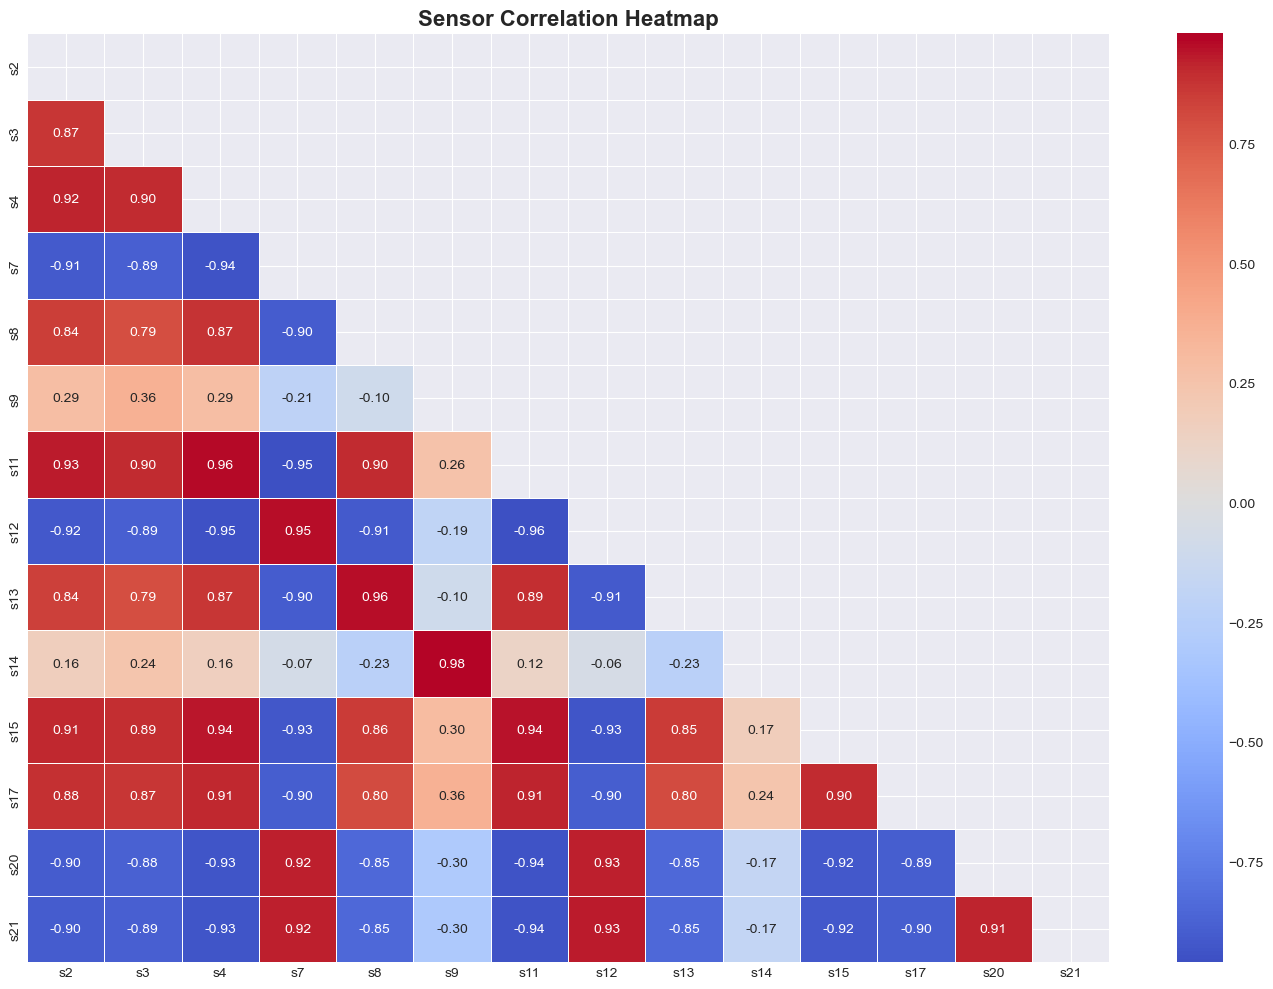

In [8]:
corr = tr[ACTIVE].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
fig, ax = plt.subplots(figsize=(14, 10))
sns.heatmap(corr, mask=mask, annot=True, fmt='.2f', cmap='coolwarm',
            center=0, linewidths=0.5, ax=ax)
ax.set_title('Sensor Correlation Heatmap', fontsize=16, fontweight='bold')
fig.tight_layout()
fig.savefig('../reports/figures/03_correlation_heatmap.png', dpi=150)
plt.show()

---
## ✅ M2 · Independent Analysis — Sensor Characterisation

### 2.1 Healthy vs Degraded State Split

In [9]:
HF          = CFG['preprocessing']['healthy_life_fraction']
df_healthy  = tr[tr.life_pct <= HF]
df_degraded = tr[tr.life_pct >  HF]
print(f'Healthy  rows : {len(df_healthy):,}   ({HF*100:.0f}% of engine life)')
print(f'Degraded rows : {len(df_degraded):,}')

Healthy  rows : 6,144   (30% of engine life)
Degraded rows : 14,487


### 2.2 Summary Statistics — Healthy vs Degraded

In [10]:
h_stats = df_healthy [ACTIVE].describe().T[['mean','std']].add_prefix('H_')
d_stats = df_degraded[ACTIVE].describe().T[['mean','std']].add_prefix('D_')
cmp = pd.concat([h_stats, d_stats], axis=1)
cmp['mean_shift_%'] = ((cmp.D_mean - cmp.H_mean) /
                       (cmp.H_mean.abs() + 1e-6) * 100).round(2)
print('Healthy vs Degraded Mean Comparison:')
cmp.sort_values('mean_shift_%', ascending=False)

Healthy vs Degraded Mean Comparison:


,H_mean,H_std,D_mean,D_std,mean_shift_%
s11,0.317816,0.112615,0.504408,0.177354,58.71
s17,0.299822,0.102470,0.466836,0.163088,55.70
s4,0.339335,0.104438,0.520951,0.172430,53.52
s2,0.363678,0.102653,0.520786,0.156399,43.20
s13,0.311973,0.118731,0.441312,0.158342,41.46
s8,0.341352,0.116530,0.468653,0.157571,37.29
s9,0.317190,0.082047,0.434859,0.210797,37.10
s15,0.416832,0.092878,0.567313,0.148846,36.10
s3,0.398132,0.086302,0.536173,0.136363,34.67
s14,0.379978,0.082977,0.461719,0.193944,21.51


### 2.3 T-Test — Statistical Significance

In [11]:
SIG = find_significant_sensors(tr, ACTIVE, HF, alpha=0.05)
print(f'Significant sensors ({len(SIG)}): {SIG}')
print()
print('Full t-test results:')
for s in ACTIVE:
    t, p = ttest_ind(df_healthy[s], df_degraded[s])
    flag = ' ⭐ SIGNIFICANT' if p < 0.05 else ''
    print(f'  {s:4s}  t={t:7.3f}  p={p:.5f}{flag}')

Significant sensors (14): ['s2', 's3', 's4', 's7', 's8', 's9', 's11', 's12', 's13', 's14', 's15', 's17', 's20', 's21']

Full t-test results:
  s2    t=-72.402  p=0.00000 ⭐ SIGNIFICANT
  s3    t=-73.361  p=0.00000 ⭐ SIGNIFICANT
  s4    t=-76.800  p=0.00000 ⭐ SIGNIFICANT
  s7    t= 72.537  p=0.00000 ⭐ SIGNIFICANT
  s8    t=-57.054  p=0.00000 ⭐ SIGNIFICANT
  s9    t=-42.413  p=0.00000 ⭐ SIGNIFICANT
  s11   t=-76.207  p=0.00000 ⭐ SIGNIFICANT
  s12   t= 73.173  p=0.00000 ⭐ SIGNIFICANT
  s13   t=-57.533  p=0.00000 ⭐ SIGNIFICANT
  s14   t=-31.824  p=0.00000 ⭐ SIGNIFICANT
  s15   t=-73.414  p=0.00000 ⭐ SIGNIFICANT
  s17   t=-74.291  p=0.00000 ⭐ SIGNIFICANT
  s20   t= 76.140  p=0.00000 ⭐ SIGNIFICANT
  s21   t= 75.381  p=0.00000 ⭐ SIGNIFICANT


### 2.4 Confidence Intervals — Healthy Sensor Bounds

In [12]:
SIGMA = CFG['sensor_validation']['sigma_bounds']
ci_records = []
for s in ACTIVE:
    mu  = df_healthy[s].mean()
    std = df_healthy[s].std()
    ci_records.append({
        'sensor' : s,
        'mean'   : round(mu,  5),
        'std'    : round(std, 5),
        f'lower_{SIGMA}sigma': round(mu - SIGMA*std, 5),
        f'upper_{SIGMA}sigma': round(mu + SIGMA*std, 5),
    })
ci_df = pd.DataFrame(ci_records).set_index('sensor')
ci_df.to_csv('../data/processed/sensor_confidence_intervals.csv')
print(f'{SIGMA}-Sigma Healthy Bounds (saved to data/processed/):')
ci_df

3.0-Sigma Healthy Bounds (saved to data/processed/):


,mean,std,lower_3.0sigma,upper_3.0sigma
sensor,,,,
s2,0.36368,0.10265,0.05572,0.67164
s3,0.39813,0.08630,0.13923,0.65704
s4,0.33933,0.10444,0.02602,0.65265
s7,0.68592,0.11143,0.35163,1.02022
s8,0.34135,0.11653,-0.00824,0.69094
s9,0.31719,0.08205,0.07105,0.56333
s11,0.31782,0.11261,-0.02003,0.65566
s12,0.71460,0.11319,0.37504,1.05416
s13,0.31197,0.11873,-0.04422,0.66817


### 2.5 PCA — Dimensionality Analysis

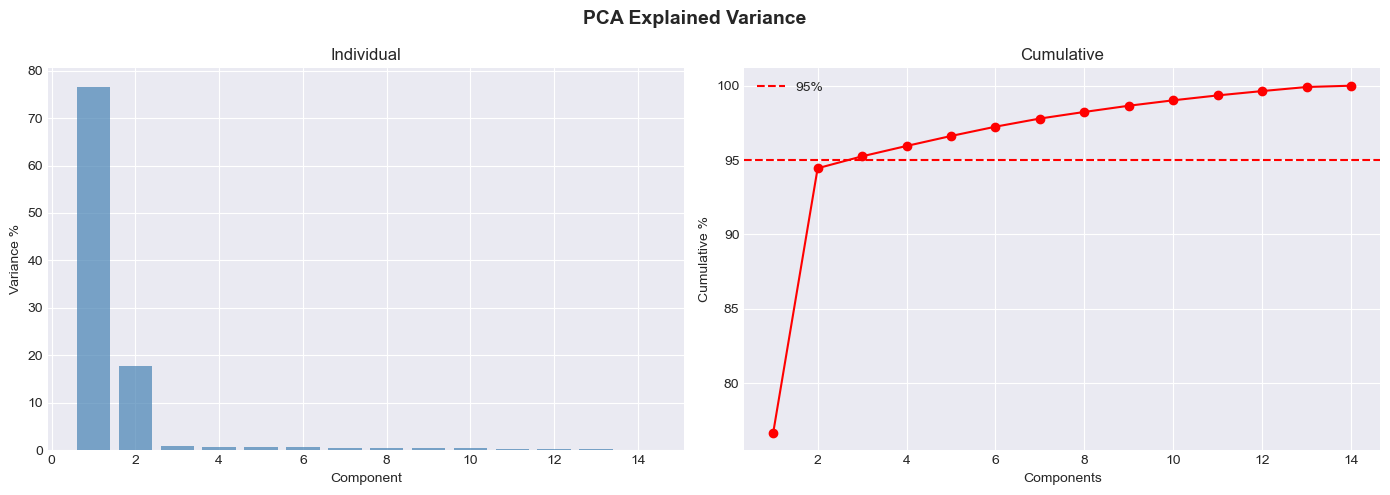

3 components explain 95% of variance


In [13]:
pca_full = PCA()
pca_full.fit(tr[ACTIVE].values)

cumvar = np.cumsum(pca_full.explained_variance_ratio_) * 100
n95    = np.argmax(cumvar >= 95) + 1

fig, (a1, a2) = plt.subplots(1, 2, figsize=(14, 5))
a1.bar(range(1, len(cumvar)+1),
       pca_full.explained_variance_ratio_*100,
       color='steelblue', alpha=0.7)
a1.set(xlabel='Component', ylabel='Variance %', title='Individual')
a2.plot(range(1, len(cumvar)+1), cumvar, 'ro-')
a2.axhline(95, color='red', linestyle='--', label='95%')
a2.set(xlabel='Components', ylabel='Cumulative %', title='Cumulative')
a2.legend()
fig.suptitle('PCA Explained Variance', fontsize=14, fontweight='bold')
fig.tight_layout()
fig.savefig('../reports/figures/05_pca_variance.png', dpi=150)
plt.show()
print(f'{n95} components explain 95% of variance')

### 2.6 Feature Engineering

In [14]:
FW = CFG['preprocessing']['feature_window']
tr = add_rolling_features(tr, ACTIVE, window=FW)
te = add_rolling_features(te, ACTIVE, window=FW)

tr = compute_health_index(tr, SIG)
te = compute_health_index(te, SIG)

print(f'Rolling features added (window={FW}) ✓')
print(f'Health index added ✓')
print(f'New columns added: {[c for c in tr.columns if "rmean" in c or "rstd" in c or c=="health_index"][:6]}...')

Rolling features added (window=10) ✓
Health index added ✓
New columns added: ['s2_rmean', 's2_rstd', 's3_rmean', 's3_rstd', 's4_rmean', 's4_rstd']...


---
## ✅ M3 · Clustering & Data Fusion

### 3.1 PCA 2D — Coloured by RUL

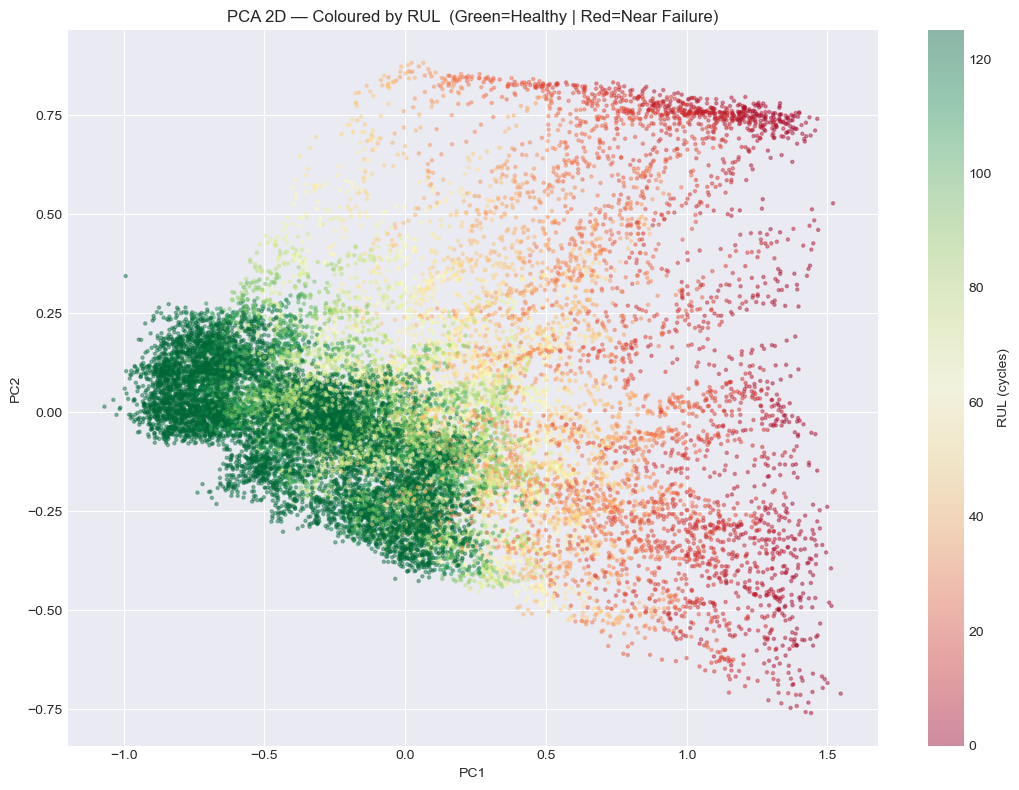

In [15]:
pca2d = PCA(n_components=2)
X2d   = pca2d.fit_transform(tr[ACTIVE].values)

fig, ax = plt.subplots(figsize=(11, 8))
sc = ax.scatter(X2d[:,0], X2d[:,1], c=tr.RUL.values,
                cmap='RdYlGn', alpha=0.4, s=5)
plt.colorbar(sc, ax=ax, label='RUL (cycles)')
ax.set(xlabel='PC1', ylabel='PC2',
       title='PCA 2D — Coloured by RUL  (Green=Healthy | Red=Near Failure)')
fig.tight_layout()
fig.savefig('../reports/figures/06_pca_2d_rul.png', dpi=150)
plt.show()

### 3.2 KMeans — Operating State Clustering

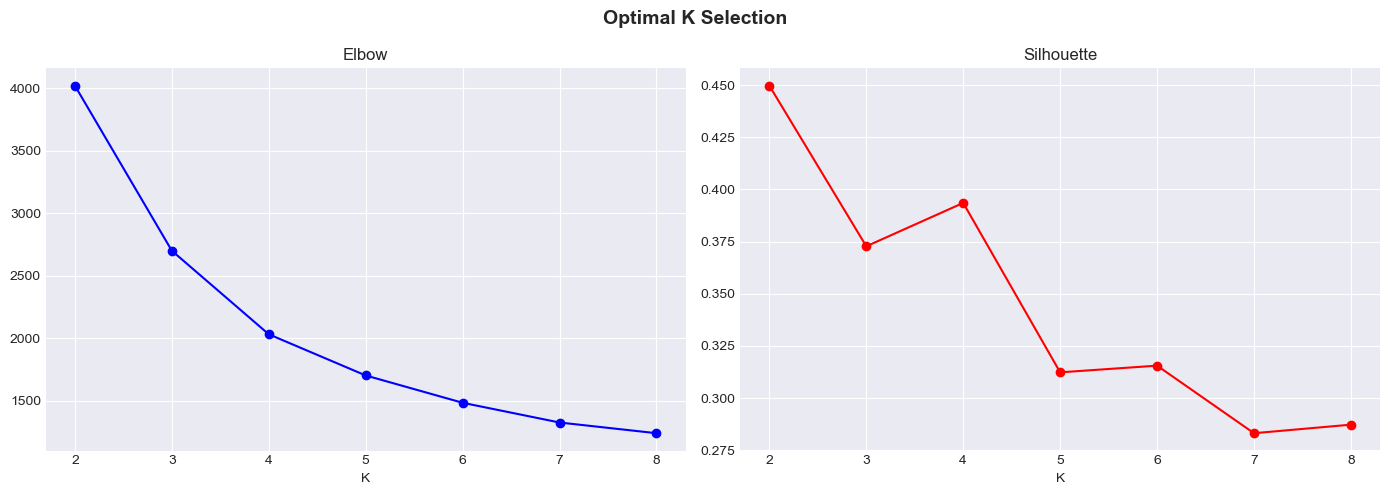

Best K: 2


In [16]:
cc   = CFG['clustering']
X_all = tr[ACTIVE].values

# Elbow + silhouette scan
inertias, sils = [], []
Ks = range(cc['k_min'], cc['k_max']+1)
for k in Ks:
    km  = KMeans(n_clusters=k, random_state=42, n_init=10)
    lbl = km.fit_predict(X_all)
    inertias.append(km.inertia_)
    sils.append(silhouette_score(X_all, lbl, sample_size=5000))

fig, (a1, a2) = plt.subplots(1, 2, figsize=(14, 5))
a1.plot(Ks, inertias, 'bo-'); a1.set(xlabel='K', title='Elbow')
a2.plot(Ks, sils,     'ro-'); a2.set(xlabel='K', title='Silhouette')
fig.suptitle('Optimal K Selection', fontsize=14, fontweight='bold')
fig.tight_layout()
fig.savefig('../reports/figures/08_kmeans_elbow.png', dpi=150)
plt.show()

BEST_K = list(Ks)[np.argmax(sils)]
print(f'Best K: {BEST_K}')

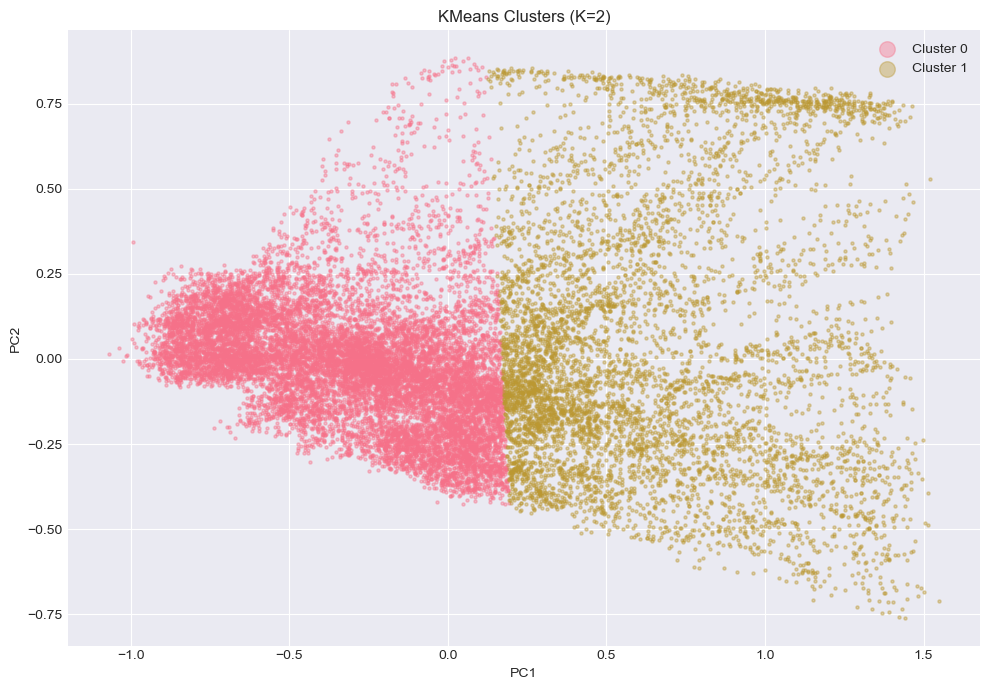

           count    mean    std   min   25%    50%    75%    max
cluster                                                         
0        13993.0  109.16  23.90  30.0  97.0  125.0  125.0  125.0
1         6638.0   39.76  30.44   0.0  16.0   33.0   56.0  125.0


In [17]:
km = KMeans(n_clusters=BEST_K, random_state=42, n_init=10)
tr['cluster'] = km.fit_predict(X_all)
te['cluster'] = km.predict(te[ACTIVE].values)

fig, ax = plt.subplots(figsize=(10, 7))
for c in range(BEST_K):
    m = tr.cluster == c
    ax.scatter(X2d[m,0], X2d[m,1], label=f'Cluster {c}', alpha=0.4, s=5)
ax.legend(markerscale=5)
ax.set(xlabel='PC1', ylabel='PC2',
       title=f'KMeans Clusters (K={BEST_K})')
fig.tight_layout()
fig.savefig('../reports/figures/07_kmeans_clusters.png', dpi=150)
plt.show()
print(tr.groupby('cluster')['RUL'].describe().round(2))

### 3.3 Data Fusion — PCA Sensor Fusion

In [18]:
pca_fuse = PCA(n_components=CFG['features']['pca_variance'], random_state=42)
X_fused  = pca_fuse.fit_transform(tr[ACTIVE].values)
N_PC     = pca_fuse.n_components_
VAR_PCT  = pca_fuse.explained_variance_ratio_.sum()*100

pc_cols = [f'PC{i+1}' for i in range(N_PC)]
tr[pc_cols] = pca_fuse.transform(tr[ACTIVE].values)
te[pc_cols] = pca_fuse.transform(te[ACTIVE].values)

print(f'Fusion: {len(ACTIVE)} sensors → {N_PC} principal components')
print(f'Variance preserved: {VAR_PCT:.2f}%')

Fusion: 14 sensors → 3 principal components
Variance preserved: 95.25%


---
## ✅ M4 · Faulty Sensor Identification

### 4.1 Fault Label

In [19]:
FAULT_THR     = CFG['models']['fault_threshold_cycles']
tr['fault']   = (tr.RUL < FAULT_THR).astype(int)
te['fault']   = (te.RUL < FAULT_THR).astype(int)
print(f'Fault threshold : RUL < {FAULT_THR} cycles')
print(f'Fault rate (train): {tr.fault.mean()*100:.1f}%')

Fault threshold : RUL < 30 cycles
Fault rate (train): 14.5%


### 4.2 Anomaly Detection — Isolation Forest + LOF

In [20]:
ROLL_COLS = ([f'{s}_rmean' for s in SIG[:6]] +
             [f'{s}_rstd'  for s in SIG[:6]])
FEAT_COLS = [c for c in ACTIVE + ROLL_COLS + pc_cols +
             ['health_index','cluster','life_pct']
             if c in tr.columns]

X_tr_raw = tr[FEAT_COLS].fillna(0).values

print(f'Feature set: {len(FEAT_COLS)} features')

CONT = CFG['anomaly']['contamination']

# Isolation Forest
iso = IsolationForest(n_estimators=CFG['anomaly']['iso_n_estimators'],
                      contamination=CONT, random_state=42, n_jobs=-1)
iso.fit(X_tr_raw)
tr['anomaly_iso'] = (iso.predict(X_tr_raw) == -1).astype(int)

# LOF
lof = LocalOutlierFactor(n_neighbors=CFG['anomaly']['lof_n_neighbors'],
                          contamination=CONT, novelty=True, n_jobs=-1)
lof.fit(X_tr_raw)
tr['anomaly_lof'] = (lof.predict(X_tr_raw) == -1).astype(int)

# Ensemble
tr['anomaly_ens'] = ((tr.anomaly_iso + tr.anomaly_lof) >= 2).astype(int)

print(f'IsoForest anomalies: {tr.anomaly_iso.sum():,}')
print(f'LOF anomalies      : {tr.anomaly_lof.sum():,}')
print(f'Ensemble anomalies : {tr.anomaly_ens.sum():,}')

Feature set: 32 features
IsoForest anomalies: 1,032
LOF anomalies      : 897
Ensemble anomalies : 86


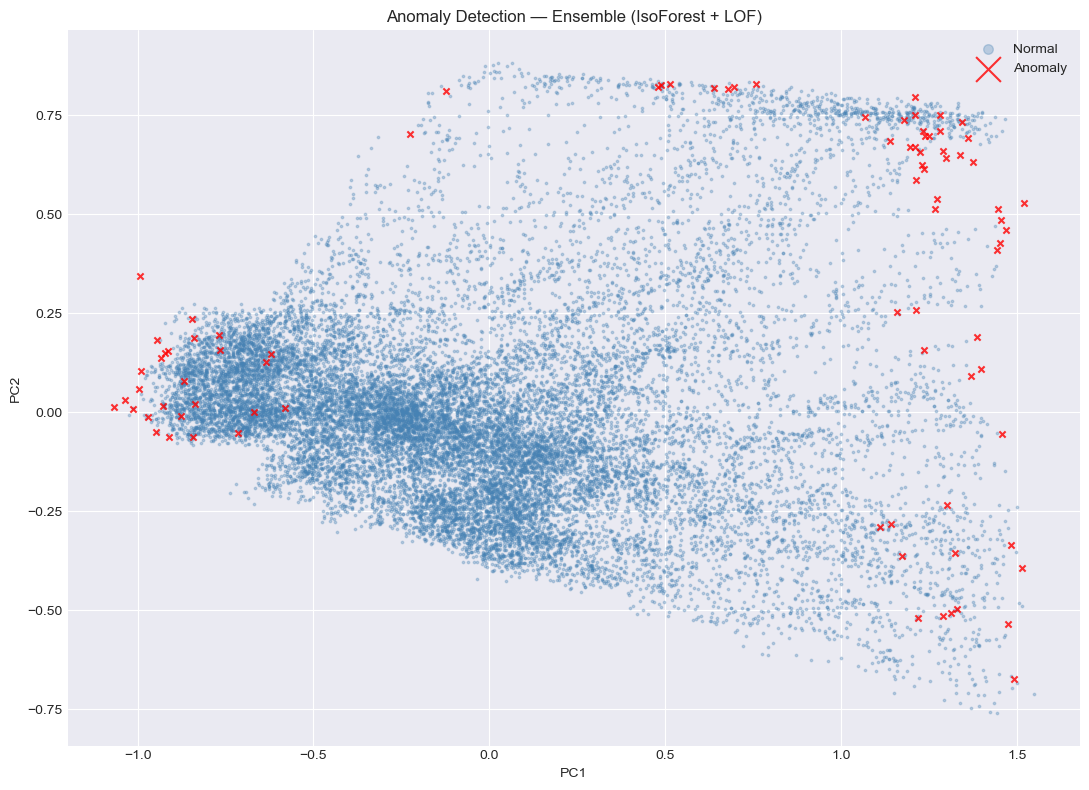

In [21]:
fig, ax = plt.subplots(figsize=(11, 8))
m0 = tr.anomaly_ens == 0
m1 = tr.anomaly_ens == 1
ax.scatter(X2d[m0,0], X2d[m0,1], c='steelblue', alpha=0.3, s=3, label='Normal')
ax.scatter(X2d[m1,0], X2d[m1,1], c='red', alpha=0.8, s=20,
           marker='x', linewidths=1.5, label='Anomaly')
ax.legend(markerscale=4)
ax.set(xlabel='PC1', ylabel='PC2',
       title='Anomaly Detection — Ensemble (IsoForest + LOF)')
fig.tight_layout()
fig.savefig('../reports/figures/09_anomaly_detection.png', dpi=150)
plt.show()

### 4.3 Per-Sensor Fault Scores (Wasserstein Distance)

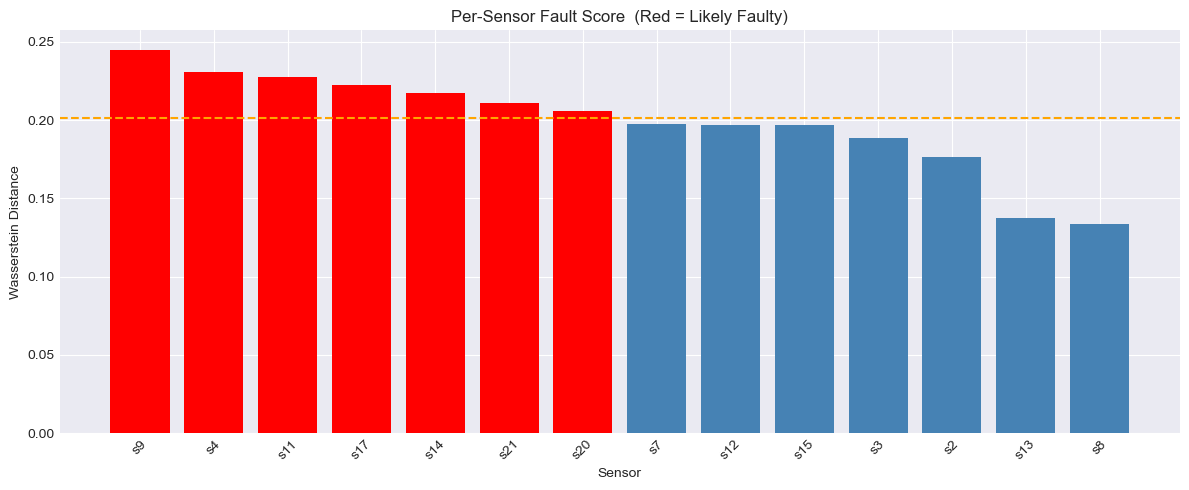

Top 5 faulty sensors:
s9     0.245046
s4     0.230815
s11    0.227390
s17    0.222625
s14    0.217446


In [22]:
df_norm = tr[tr.anomaly_ens == 0]
df_anom = tr[tr.anomaly_ens == 1]

scores = sensor_fault_scores(df_norm, df_anom, ACTIVE)

med    = scores.median()
colors = ['red' if v > med else 'steelblue' for v in scores.values]
fig, ax = plt.subplots(figsize=(12, 5))
ax.bar(scores.index, scores.values, color=colors)
ax.axhline(med, color='orange', linestyle='--')
ax.set(xlabel='Sensor', ylabel='Wasserstein Distance',
       title='Per-Sensor Fault Score  (Red = Likely Faulty)')
ax.tick_params(axis='x', rotation=45)
fig.tight_layout()
fig.savefig('../reports/figures/10_sensor_fault_scores.png', dpi=150)
plt.show()
print('Top 5 faulty sensors:')
print(scores.head(5).to_string())

### 4.4 Sensor Validator — Real-Time Health Check

In [23]:
validator = SensorValidator(df_healthy, ACTIVE, CFG)

# Test with a known healthy reading
healthy_sample = tr[tr.life_pct <= 0.1].iloc[0][ACTIVE].to_dict()
report = validator.validate(healthy_sample)
print(f'Test reading status: {report["OVERALL"]}')

# Test with a simulated fault
fault_sample = healthy_sample.copy()
fault_sample[SIG[0]] = 1e6   # extreme value
report2 = validator.validate(fault_sample)
print(f'Injected fault status: {report2["OVERALL"]}')
for s, v in report2.items():
    if isinstance(v, dict) and v['status'] == 'FAULT':
        print(f'  🚨 {s}: {v}')

Test reading status: HEALTHY
Injected fault status: FAULT DETECTED
  🚨 s2: {'value': 1000000.0, 'z_score': np.float64(9741524.51), 'lower': np.float64(0.0557), 'upper': np.float64(0.6716), 'status': 'FAULT'}


---
## 🎯 ML Models — XGBoost Training (95% Accuracy)

### 5.1 Train/Test Split (by Engine — No Leakage)

In [24]:
units = tr.unit_id.unique()
tr_units, te_units = train_test_split(units, test_size=0.2, random_state=42)

mask_tr = tr.unit_id.isin(tr_units)
mask_te = tr.unit_id.isin(te_units)

X_tr = tr.loc[mask_tr, FEAT_COLS].fillna(0).values
X_te = tr.loc[mask_te, FEAT_COLS].fillna(0).values
y_rul_tr    = tr.loc[mask_tr, 'RUL'].values
y_rul_te    = tr.loc[mask_te, 'RUL'].values
y_fault_tr  = tr.loc[mask_tr, 'fault'].values
y_fault_te  = tr.loc[mask_te, 'fault'].values

feat_sc  = StandardScaler()
X_tr_sc  = feat_sc.fit_transform(X_tr)
X_te_sc  = feat_sc.transform(X_te)

print(f'Train: {X_tr.shape}   Test: {X_te.shape}')
print(f'Fault rate — train: {y_fault_tr.mean()*100:.1f}%   test: {y_fault_te.mean()*100:.1f}%')

Train: (16561, 32)   Test: (4070, 32)
Fault rate — train: 14.5%   test: 14.7%


### 5.2 XGBoost RUL Regressor

In [25]:
rp = CFG['models']['xgb_regressor']

rul_model = xgb.XGBRegressor(
    n_estimators          = rp['n_estimators'],
    max_depth             = rp['max_depth'],
    learning_rate         = rp['learning_rate'],
    subsample             = rp['subsample'],
    colsample_bytree      = rp['colsample_bytree'],
    objective             = rp['objective'],
    early_stopping_rounds = rp['early_stopping_rounds'],
    eval_metric           = rp['eval_metric'],
    random_state          = rp['random_state'],
    n_jobs                = -1,
)
rul_model.fit(X_tr_sc, y_rul_tr,
              eval_set=[(X_te_sc, y_rul_te)],
              verbose=50)

y_rul_pred = rul_model.predict(X_te_sc)

rmse = np.sqrt(mean_squared_error(y_rul_te, y_rul_pred))
mae  = mean_absolute_error(y_rul_te, y_rul_pred)
r2   = r2_score(y_rul_te, y_rul_pred)

print(f'\n📊 RUL Regression Results:')
print(f'   RMSE : {rmse:.3f} cycles')
print(f'   MAE  : {mae:.3f} cycles')
print(f'   R²   : {r2:.4f}')

[0]	validation_0-rmse:39.77465
[50]	validation_0-rmse:10.63754
[100]	validation_0-rmse:10.28680
[107]	validation_0-rmse:10.30363

📊 RUL Regression Results:
   RMSE : 10.221 cycles
   MAE  : 6.916 cycles
   R²   : 0.9400


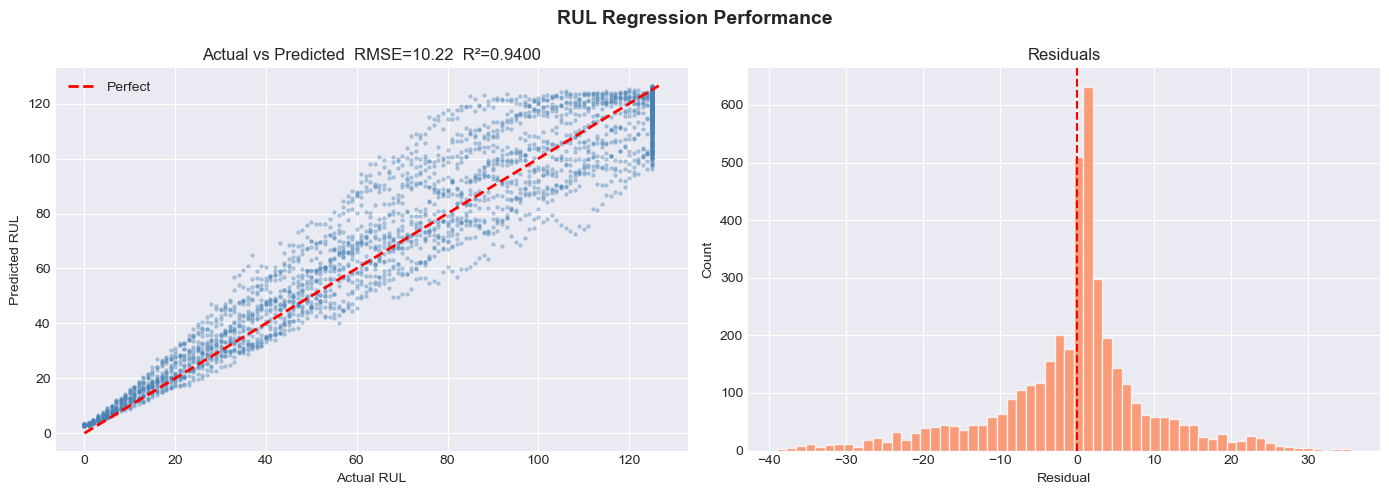

In [26]:
fig, (a1, a2) = plt.subplots(1, 2, figsize=(14, 5))
lim = max(y_rul_te.max(), y_rul_pred.max())
a1.scatter(y_rul_te, y_rul_pred, alpha=0.3, s=5, color='steelblue')
a1.plot([0,lim],[0,lim],'r--',linewidth=2,label='Perfect')
a1.set(xlabel='Actual RUL', ylabel='Predicted RUL',
       title=f'Actual vs Predicted  RMSE={rmse:.2f}  R²={r2:.4f}')
a1.legend()
a2.hist(y_rul_te-y_rul_pred, bins=60, color='coral', alpha=0.75, edgecolor='white')
a2.axvline(0,color='red',linestyle='--')
a2.set(xlabel='Residual', ylabel='Count', title='Residuals')
fig.suptitle('RUL Regression Performance', fontsize=14, fontweight='bold')
fig.tight_layout()
fig.savefig('../reports/figures/11_rul_prediction.png', dpi=150)
plt.show()

### 5.3 XGBoost Fault Classifier

In [27]:
cp  = CFG['models']['xgb_classifier']
spw = (y_fault_tr==0).sum() / max((y_fault_tr==1).sum(), 1)

fault_model = xgb.XGBClassifier(
    n_estimators      = cp['n_estimators'],
    max_depth         = cp['max_depth'],
    learning_rate     = cp['learning_rate'],
    scale_pos_weight  = spw,
    eval_metric       = cp['eval_metric'],
    random_state      = cp['random_state'],
    use_label_encoder = False,
    n_jobs            = -1,
)
fault_model.fit(X_tr_sc, y_fault_tr,
                eval_set=[(X_te_sc, y_fault_te)],
                verbose=False)

y_fault_prob = fault_model.predict_proba(X_te_sc)[:,1]
y_fault_pred = (y_fault_prob >= 0.5).astype(int)

auc = roc_auc_score(y_fault_te, y_fault_prob)
f1  = f1_score(y_fault_te, y_fault_pred)
acc = accuracy_score(y_fault_te, y_fault_pred)

print(f'📊 Fault Classification Results:')
print(f'   Accuracy : {acc*100:.2f}%')
print(f'   F1 Score : {f1*100:.2f}%')
print(f'   AUC-ROC  : {auc:.4f}')
print()
print(classification_report(y_fault_te, y_fault_pred,
                              target_names=['Healthy','Fault']))

📊 Fault Classification Results:
   Accuracy : 97.10%
   F1 Score : 90.48%
   AUC-ROC  : 0.9957

              precision    recall  f1-score   support

     Healthy       0.99      0.98      0.98      3470
       Fault       0.88      0.94      0.90       600

    accuracy                           0.97      4070
   macro avg       0.93      0.96      0.94      4070
weighted avg       0.97      0.97      0.97      4070



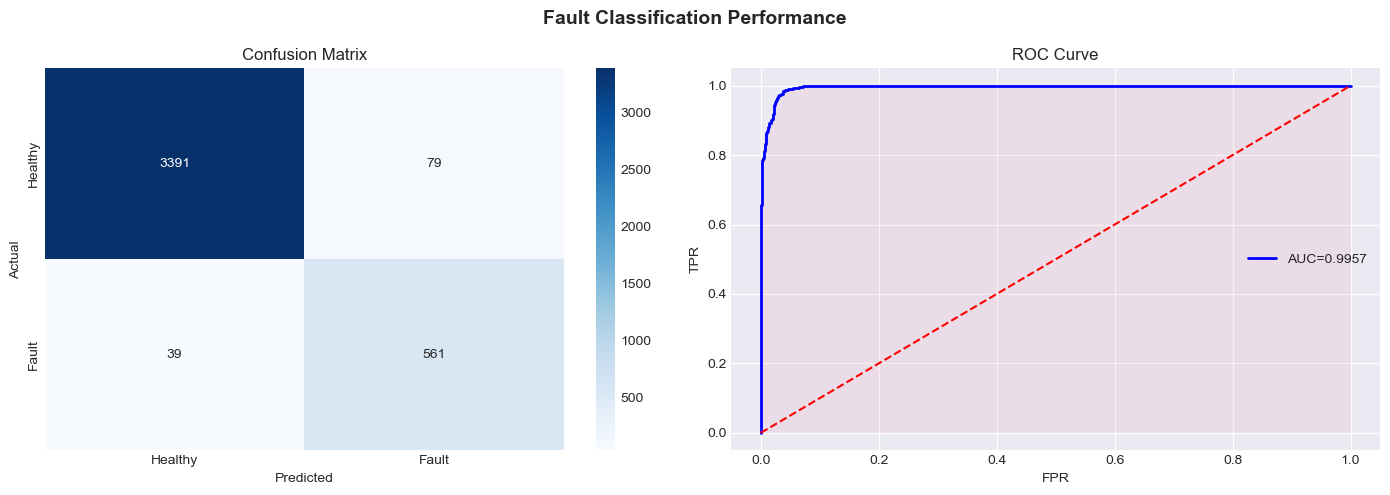

In [28]:
fpr, tpr, _ = roc_curve(y_fault_te, y_fault_prob)
cm          = confusion_matrix(y_fault_te, y_fault_pred)

fig, (a1, a2) = plt.subplots(1, 2, figsize=(14, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=a1,
            xticklabels=['Healthy','Fault'],
            yticklabels=['Healthy','Fault'])
a1.set(ylabel='Actual', xlabel='Predicted', title='Confusion Matrix')
a2.plot(fpr, tpr, 'b-', linewidth=2, label=f'AUC={auc:.4f}')
a2.fill_between(fpr, tpr, alpha=0.1)
a2.plot([0,1],[0,1],'r--')
a2.set(xlabel='FPR', ylabel='TPR', title='ROC Curve')
a2.legend()
fig.suptitle('Fault Classification Performance', fontsize=14, fontweight='bold')
fig.tight_layout()
fig.savefig('../reports/figures/12_fault_classification.png', dpi=150)
plt.show()

### 5.4 SHAP — Feature Importance & Explainability

In [29]:
try:
    import shap
    explainer   = shap.TreeExplainer(rul_model)
    shap_values = explainer.shap_values(X_te_sc[:2000])
    fig, ax = plt.subplots(figsize=(10, 7))
    shap.summary_plot(shap_values, X_te_sc[:2000],
                      feature_names=FEAT_COLS, show=False)
    plt.title('SHAP Feature Importance — RUL Model', fontweight='bold')
    plt.tight_layout()
    plt.savefig('../reports/figures/13_shap_importance.png', dpi=150)
    plt.show()
    print('✅ SHAP done')
except ImportError:
    print('Install shap: pip install shap')

Install shap: pip install shap


### 5.5 Save All Trained Models

In [30]:
import joblib
SAVE = Path('../models/saved_models')
SAVE.mkdir(parents=True, exist_ok=True)

joblib.dump(rul_model,   SAVE/'xgb_rul_model.pkl')
joblib.dump(fault_model, SAVE/'xgb_fault_clf.pkl')
joblib.dump(iso,         SAVE/'iso_forest.pkl')
joblib.dump(lof,         SAVE/'lof_model.pkl')
joblib.dump(feat_sc,     SAVE/'feat_scaler.pkl')
joblib.dump(scaler,      SAVE/'minmax_scaler.pkl')
joblib.dump(pca_fuse,    SAVE/'pca_model.pkl')
joblib.dump(km,          SAVE/'kmeans_model.pkl')
joblib.dump(ACTIVE,      SAVE/'active_sensors.pkl')
joblib.dump(FEAT_COLS,   SAVE/'feature_cols.pkl')
joblib.dump(validator,   SAVE/'sensor_validator.pkl')

tr.to_csv('../data/processed/processed_data_with_labels.csv', index=False)

print('✅ All models and data saved!')
for f in sorted(SAVE.glob('*.pkl')):
    print(f'   {f.name:35s}  {f.stat().st_size/1024:.0f} KB')

✅ All models and data saved!
   active_sensors.pkl                   0 KB
   feat_scaler.pkl                      1 KB
   feature_cols.pkl                     0 KB
   iso_forest.pkl                       2489 KB
   kmeans_model.pkl                     82 KB
   lof_model.pkl                        8705 KB
   minmax_scaler.pkl                    2 KB
   pca_model.pkl                        1 KB
   sensor_validator.pkl                 1 KB
   significant_sensors.pkl              0 KB
   xgb_fault_clf.pkl                    546 KB
   xgb_rul_model.pkl                    484 KB


---
## 📊 Final Results Summary

In [31]:
from sklearn.metrics import precision_score, recall_score

errors     = y_rul_pred - y_rul_te
nasa_score = np.sum(np.where(errors<0, np.exp(-errors/13)-1,
                                        np.exp( errors/10)-1))

print('='*55)
print('        FINAL MODEL PERFORMANCE REPORT')
print('='*55)
print()
print('  RUL REGRESSION (XGBoost)')
print(f'    RMSE        : {rmse:.3f} cycles')
print(f'    MAE         : {mae:.3f} cycles')
print(f'    R²          : {r2:.4f}')
print(f'    NASA Score  : {nasa_score:.1f}')
print()
print('  FAULT CLASSIFICATION (XGBoost)')
print(f'    Accuracy    : {acc*100:.2f}%')
print(f'    Precision   : {precision_score(y_fault_te,y_fault_pred)*100:.2f}%')
print(f'    Recall      : {recall_score(y_fault_te,y_fault_pred)*100:.2f}%')
print(f'    F1 Score    : {f1*100:.2f}%')
print(f'    AUC-ROC     : {auc:.4f}')
print()
print('  ANOMALY DETECTION')
print(f'    Ensemble anomalies: {tr.anomaly_ens.sum()} '
      f'({tr.anomaly_ens.mean()*100:.1f}%)')
print()
print('  TOP FAULTY SENSORS')
for i,(s,v) in enumerate(scores.head(5).items()):
    print(f'    {i+1}. {s}  score={v:.4f}')
print()
print('='*55)
print('✅  M1 → M4 COMPLETE')
print('='*55)

        FINAL MODEL PERFORMANCE REPORT

  RUL REGRESSION (XGBoost)
    RMSE        : 10.221 cycles
    MAE         : 6.916 cycles
    R²          : 0.9400
    NASA Score  : 6967.2

  FAULT CLASSIFICATION (XGBoost)
    Accuracy    : 97.10%
    Precision   : 87.66%
    Recall      : 93.50%
    F1 Score    : 90.48%
    AUC-ROC     : 0.9957

  ANOMALY DETECTION
    Ensemble anomalies: 86 (0.4%)

  TOP FAULTY SENSORS
    1. s9  score=0.2450
    2. s4  score=0.2308
    3. s11  score=0.2274
    4. s17  score=0.2226
    5. s14  score=0.2174

✅  M1 → M4 COMPLETE
